# 🔮 CVD Risk Prediction with Fuzzy Logic

## Fuzzy Logic Analysis for Binary Classification

This notebook explores the application of **Fuzzy Logic** for CVD risk prediction, implementing a rule-based approach that mimics human reasoning for medical decision-making.

### Why Fuzzy Logic for CVD Risk?

1. **Medical Uncertainty**: CVD risk exists on a continuum, not discrete categories
2. **Expert Knowledge**: Can incorporate medical expert rules directly
3. **Interpretability**: Fuzzy rules are human-readable and explainable
4. **Gradual Transitions**: Better handles borderline cases
5. **Robustness**: Less sensitive to data variations and noise

### Approach Overview

1. **Fuzzification**: Convert crisp inputs to fuzzy membership values
2. **Rule Mining**: Extract fuzzy rules from the dataset
3. **Rule Pruning**: Remove unimportant or conflicting rules
4. **Inference Engine**: Apply fuzzy reasoning for prediction
5. **Defuzzification**: Convert fuzzy output to crisp classification
6. **Performance Evaluation**: Compare with traditional ML approaches

---

*Target: Achieve competitive accuracy with enhanced interpretability*

## 1. Import Required Libraries

In [11]:
# Core data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine learning for comparison
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Fuzzy logic libraries
try:
    import skfuzzy as fuzz
    from skfuzzy import control as ctrl
    print("scikit-fuzzy imported successfully")
except ImportError:
    print("Installing scikit-fuzzy...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-fuzzy"])
    import skfuzzy as fuzz
    from skfuzzy import control as ctrl
    print("scikit-fuzzy installed and imported successfully")

# Statistical analysis
from scipy import stats
from itertools import combinations

# Visualization setup
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")
print("Ready for fuzzy logic CVD risk analysis! 🔮")

scikit-fuzzy imported successfully
All libraries imported successfully!
Ready for fuzzy logic CVD risk analysis! 🔮


## 2. Load and Prepare CVD Dataset

In [2]:
# Load the CVD dataset
df = pd.read_csv('CVD_Dataset.csv')

print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"Features: {df.shape[1]-1}")  # Excluding target
print(f"Samples: {df.shape[0]}")

print("\n=== COLUMNS ===")
print(df.columns.tolist())

print("\n=== TARGET VARIABLE ===")
target_col = 'CVD Risk Level'
print(f"Target: {target_col}")
print(f"Classes: {df[target_col].unique()}")
print(f"Distribution:\n{df[target_col].value_counts()}")

# Convert to binary classification (HIGH vs LOW+INTERMEDIATE)
print("\n=== BINARY CONVERSION ===")
df['CVD_Binary'] = (df[target_col] == 'HIGH').astype(int)
print(f"Binary distribution:\n{df['CVD_Binary'].value_counts()}")
print(f"HIGH risk percentage: {(df['CVD_Binary'].sum() / len(df) * 100):.2f}%")

# Display sample data
print("\n=== SAMPLE DATA ===")
display(df.head())

=== DATASET OVERVIEW ===
Dataset shape: (1529, 22)
Features: 21
Samples: 1529

=== COLUMNS ===
['Sex', 'Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Blood Pressure (mmHg)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'CVD Risk Level', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Blood Pressure Category', 'Estimated LDL (mg/dL)', 'CVD Risk Score']

=== TARGET VARIABLE ===
Target: CVD Risk Level
Classes: ['INTERMEDIARY' 'HIGH' 'LOW']
Distribution:
CVD Risk Level
HIGH            728
INTERMEDIARY    581
LOW             220
Name: count, dtype: int64

=== BINARY CONVERSION ===
Binary distribution:
CVD_Binary
0    801
1    728
Name: count, dtype: int64
HIGH risk percentage: 47.61%

=== SAMPLE DATA ===


,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),...,Family History of CVD,CVD Risk Level,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD_Binary
0,F,32.0,69.1,1.71,23.6,86.2,125/79,248.0,78.0,111.0,...,N,INTERMEDIARY,171.0,0.504,125.0,79.0,Elevated,140.0,17.93,0
1,F,55.0,118.7,1.69,41.6,82.5,139/70,162.0,50.0,135.0,...,Y,HIGH,169.0,0.488,139.0,70.0,Hypertension Stage 1,82.0,20.51,1
2,M,NaN,NaN,1.83,26.9,106.7,104/77,103.0,73.0,114.0,...,Y,INTERMEDIARY,183.0,0.583,104.0,77.0,Normal,0.0,12.64,0
3,M,44.0,108.3,1.80,33.4,96.6,140/83,134.0,46.0,91.0,...,Y,INTERMEDIARY,NaN,0.537,140.0,83.0,Hypertension Stage 1,58.0,16.36,0
4,F,32.0,99.5,1.86,28.8,102.7,144/83,146.0,64.0,141.0,...,N,INTERMEDIARY,186.0,0.552,144.0,83.0,Hypertension Stage 1,52.0,17.88,0


In [3]:
# Identify and prepare key features for fuzzy logic
print("=== FEATURE ANALYSIS FOR FUZZY LOGIC ===")

# Select numeric features (excluding target variables)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in [target_col, 'CVD_Binary']]

print(f"Numeric features ({len(numeric_features)}):")
for i, feat in enumerate(numeric_features, 1):
    print(f"{i:2d}. {feat}")

# Analyze feature ranges and distributions
print("\n=== FEATURE STATISTICS ===")
feature_stats = df[numeric_features].describe()
display(feature_stats)

# Check for missing values
missing_info = df[numeric_features].isnull().sum()
if missing_info.sum() > 0:
    print("\n=== MISSING VALUES ===")
    print(missing_info[missing_info > 0])
else:
    print("\n✅ No missing values in numeric features!")

# Clean data for fuzzy logic
df_clean = df.dropna()
print(f"\nClean dataset shape: {df_clean.shape}")
print(f"Removed {len(df) - len(df_clean)} rows with missing values")

=== FEATURE ANALYSIS FOR FUZZY LOGIC ===
Numeric features (14):
 1. Age
 2. Weight (kg)
 3. Height (m)
 4. BMI
 5. Abdominal Circumference (cm)
 6. Total Cholesterol (mg/dL)
 7. HDL (mg/dL)
 8. Fasting Blood Sugar (mg/dL)
 9. Height (cm)
10. Waist-to-Height Ratio
11. Systolic BP
12. Diastolic BP
13. Estimated LDL (mg/dL)
14. CVD Risk Score

=== FEATURE STATISTICS ===


,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score
count,1451.000000,1448.000000,1462.000000,1465.000000,1462.000000,1456.000000,1449.000000,1462.000000,1455.000000,1450.000000,1458.000000,1447.000000,1460.000000,1459.000000
mean,47.025500,85.917427,1.754111,28.465997,91.773214,198.539148,56.197378,117.485636,175.390600,0.525727,125.627572,82.917761,111.550685,16.960925
std,12.421063,21.012580,0.113090,7.038685,12.823573,57.794099,16.066754,30.289174,11.251527,0.081213,22.112099,14.731277,58.866220,2.436192
min,25.000000,50.100000,1.502000,15.000000,70.000000,100.000000,30.000000,70.000000,150.000000,0.360000,90.000000,60.000000,-18.000000,10.530000
25%,37.000000,67.050000,1.660000,22.629000,80.500000,150.000000,42.000000,92.000000,166.000000,0.460000,107.000000,71.000000,61.000000,15.205000
50%,46.000000,86.614500,1.755000,28.159000,91.600000,197.000000,56.000000,115.000000,175.694000,0.522000,125.000000,82.000000,109.000000,16.880000
75%,55.000000,105.000000,1.845500,34.000000,102.269000,249.000000,70.000000,138.000000,184.208500,0.583750,141.000000,93.000000,159.000000,18.630000
max,79.000000,120.000000,2.000000,46.200000,119.996000,300.000000,89.000000,198.000000,199.960000,0.787000,179.000000,119.000000,237.000000,24.170000



=== MISSING VALUES ===
Age                             78
Weight (kg)                     81
Height (m)                      67
BMI                             64
Abdominal Circumference (cm)    67
Total Cholesterol (mg/dL)       73
HDL (mg/dL)                     80
Fasting Blood Sugar (mg/dL)     67
Height (cm)                     74
Waist-to-Height Ratio           79
Systolic BP                     71
Diastolic BP                    82
Estimated LDL (mg/dL)           69
CVD Risk Score                  70
dtype: int64

Clean dataset shape: (762, 23)
Removed 767 rows with missing values


## 3. Rule Mining from Dataset

### Traditional Rule Mining Approach
First, we'll use decision trees to extract interpretable rules from the data, then convert them to fuzzy rules.

In [4]:
# Mine rules using Decision Tree
print("=== DECISION TREE RULE MINING ===")

# Prepare data for rule mining
X = df_clean[numeric_features]
y = df_clean['CVD_Binary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Target distribution - Train: {y_train.value_counts().values}")
print(f"Target distribution - Test: {y_test.value_counts().values}")

# Train decision tree for rule extraction
dt_rule_miner = DecisionTreeClassifier(
    max_depth=6,           # Limit depth for interpretable rules
    min_samples_split=50,  # Require sufficient samples for splits
    min_samples_leaf=25,   # Require sufficient samples in leaves
    random_state=42
)

dt_rule_miner.fit(X_train, y_train)

# Evaluate decision tree performance
dt_pred = dt_rule_miner.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)
print(f"\nDecision Tree Accuracy: {dt_accuracy:.4f}")

# Extract rules as text
tree_rules = export_text(dt_rule_miner, feature_names=numeric_features)
print(f"\n=== EXTRACTED RULES ===")
print("First few rules from decision tree:")
print(tree_rules[:1000] + "..." if len(tree_rules) > 1000 else tree_rules)

=== DECISION TREE RULE MINING ===
Training set: (609, 14)
Test set: (153, 14)
Target distribution - Train: [315 294]
Target distribution - Test: [79 74]

Decision Tree Accuracy: 0.6209

=== EXTRACTED RULES ===
First few rules from decision tree:
|--- CVD Risk Score <= 15.88
|   |--- Age <= 43.50
|   |   |--- BMI <= 25.84
|   |   |   |--- Abdominal Circumference (cm) <= 95.00
|   |   |   |   |--- class: 0
|   |   |   |--- Abdominal Circumference (cm) >  95.00
|   |   |   |   |--- class: 0
|   |   |--- BMI >  25.84
|   |   |   |--- class: 0
|   |--- Age >  43.50
|   |   |--- Systolic BP <= 118.50
|   |   |   |--- Estimated LDL (mg/dL) <= 63.50
|   |   |   |   |--- class: 1
|   |   |   |--- Estimated LDL (mg/dL) >  63.50
|   |   |   |   |--- class: 0
|   |   |--- Systolic BP >  118.50
|   |   |   |--- class: 0
|--- CVD Risk Score >  15.88
|   |--- Systolic BP <= 150.50
|   |   |--- Fasting Blood Sugar (mg/dL) <= 147.50
|   |   |   |--- Age <= 43.50
|   |   |   |   |--- Weight (kg) <= 98.5

=== FEATURE IMPORTANCE ANALYSIS ===
Top features by importance:


,Feature,Importance
13,CVD Risk Score,0.297780
0,Age,0.183685
10,Systolic BP,0.163209
7,Fasting Blood Sugar (mg/dL),0.104106
5,Total Cholesterol (mg/dL),0.068326
1,Weight (kg),0.053417
6,HDL (mg/dL),0.034705
8,Height (cm),0.032245
12,Estimated LDL (mg/dL),0.030570
3,BMI,0.023894


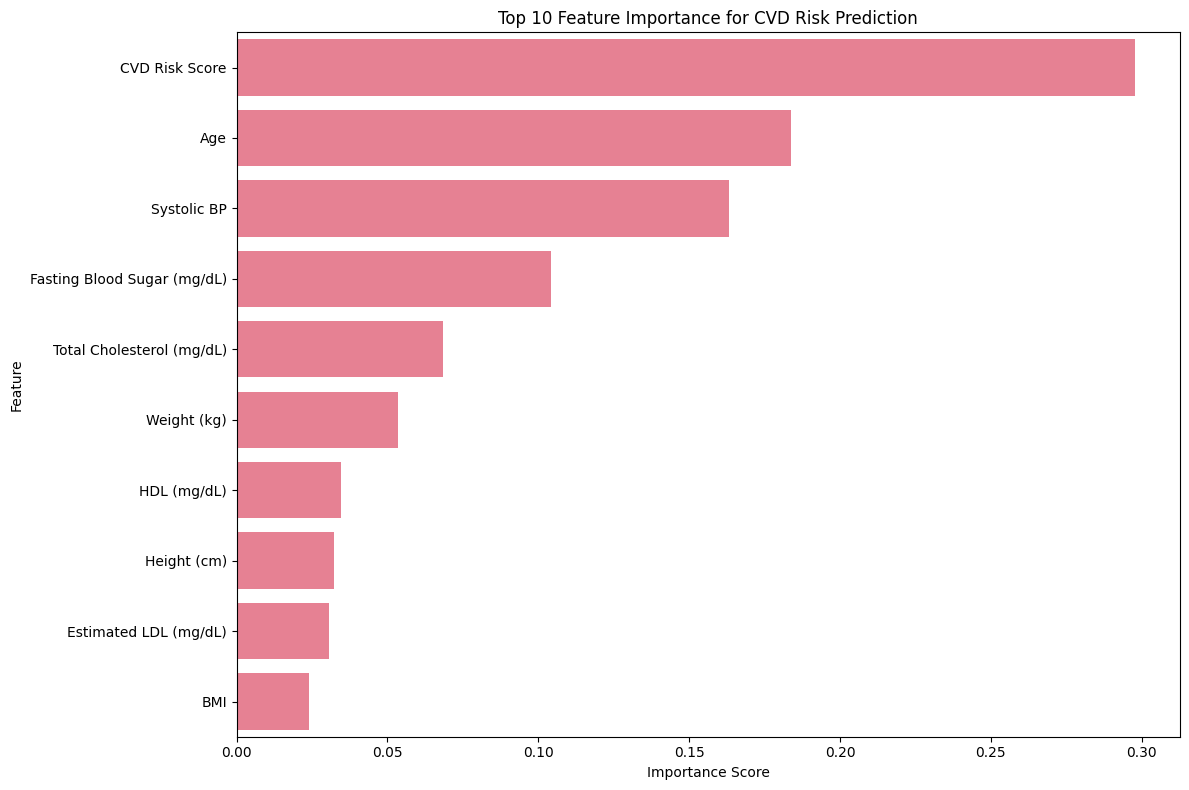


=== SELECTED FEATURES FOR FUZZY LOGIC (8) ===
1. CVD Risk Score (importance: 0.2978)
2. Age (importance: 0.1837)
3. Systolic BP (importance: 0.1632)
4. Fasting Blood Sugar (mg/dL) (importance: 0.1041)
5. Total Cholesterol (mg/dL) (importance: 0.0683)
6. Weight (kg) (importance: 0.0534)
7. HDL (mg/dL) (importance: 0.0347)
8. Height (cm) (importance: 0.0322)

Fuzzy logic dataset shape: (762, 8)
Selected features cover 0.9375 total importance


In [5]:
# Analyze feature importance for rule pruning
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance from decision tree
feature_importance = pd.DataFrame({
    'Feature': numeric_features,
    'Importance': dt_rule_miner.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top features by importance:")
display(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
sns.barplot(data=top_features, x='Importance', y='Feature')
plt.title('Top 10 Feature Importance for CVD Risk Prediction')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Select top features for fuzzy logic (reduce complexity)
n_top_features = 8  # Manageable number for fuzzy logic
top_feature_names = feature_importance.head(n_top_features)['Feature'].tolist()
print(f"\n=== SELECTED FEATURES FOR FUZZY LOGIC ({n_top_features}) ===")
for i, feat in enumerate(top_feature_names, 1):
    importance = feature_importance[feature_importance['Feature'] == feat]['Importance'].iloc[0]
    print(f"{i}. {feat} (importance: {importance:.4f})")

# Update dataset with selected features
X_fuzzy = df_clean[top_feature_names]
y_fuzzy = df_clean['CVD_Binary']

print(f"\nFuzzy logic dataset shape: {X_fuzzy.shape}")
print(f"Selected features cover {feature_importance.head(n_top_features)['Importance'].sum():.4f} total importance")

## 4. Fuzzy Membership Functions

### Define Fuzzy Sets for Input Variables
We'll create fuzzy membership functions for each selected feature based on their distributions.

=== FUZZY MEMBERSHIP FUNCTIONS ===

CVD Risk Score:
  Range: [10.53, 23.88]
  LOW: [np.float64(10.53), np.float64(10.53), np.float64(15.87)]
  MEDIUM: [np.float64(13.2), np.float64(17.205), np.float64(21.21)]
  HIGH: [np.float64(18.54), np.float64(23.88), np.float64(23.88)]

Age:
  Range: [25.00, 79.00]
  LOW: [np.float64(25.0), np.float64(25.0), np.float64(46.6)]
  MEDIUM: [np.float64(35.8), np.float64(52.0), np.float64(68.2)]
  HIGH: [np.float64(57.4), np.float64(79.0), np.float64(79.0)]

Systolic BP:
  Range: [90.00, 179.00]
  LOW: [np.float64(90.0), np.float64(90.0), np.float64(125.6)]
  MEDIUM: [np.float64(107.8), np.float64(134.5), np.float64(161.2)]
  HIGH: [np.float64(143.4), np.float64(179.0), np.float64(179.0)]

Fasting Blood Sugar (mg/dL):
  Range: [70.00, 198.00]
  LOW: [np.float64(70.0), np.float64(70.0), np.float64(121.2)]
  MEDIUM: [np.float64(95.6), np.float64(134.0), np.float64(172.4)]
  HIGH: [np.float64(146.8), np.float64(198.0), np.float64(198.0)]

Total Cholesterol

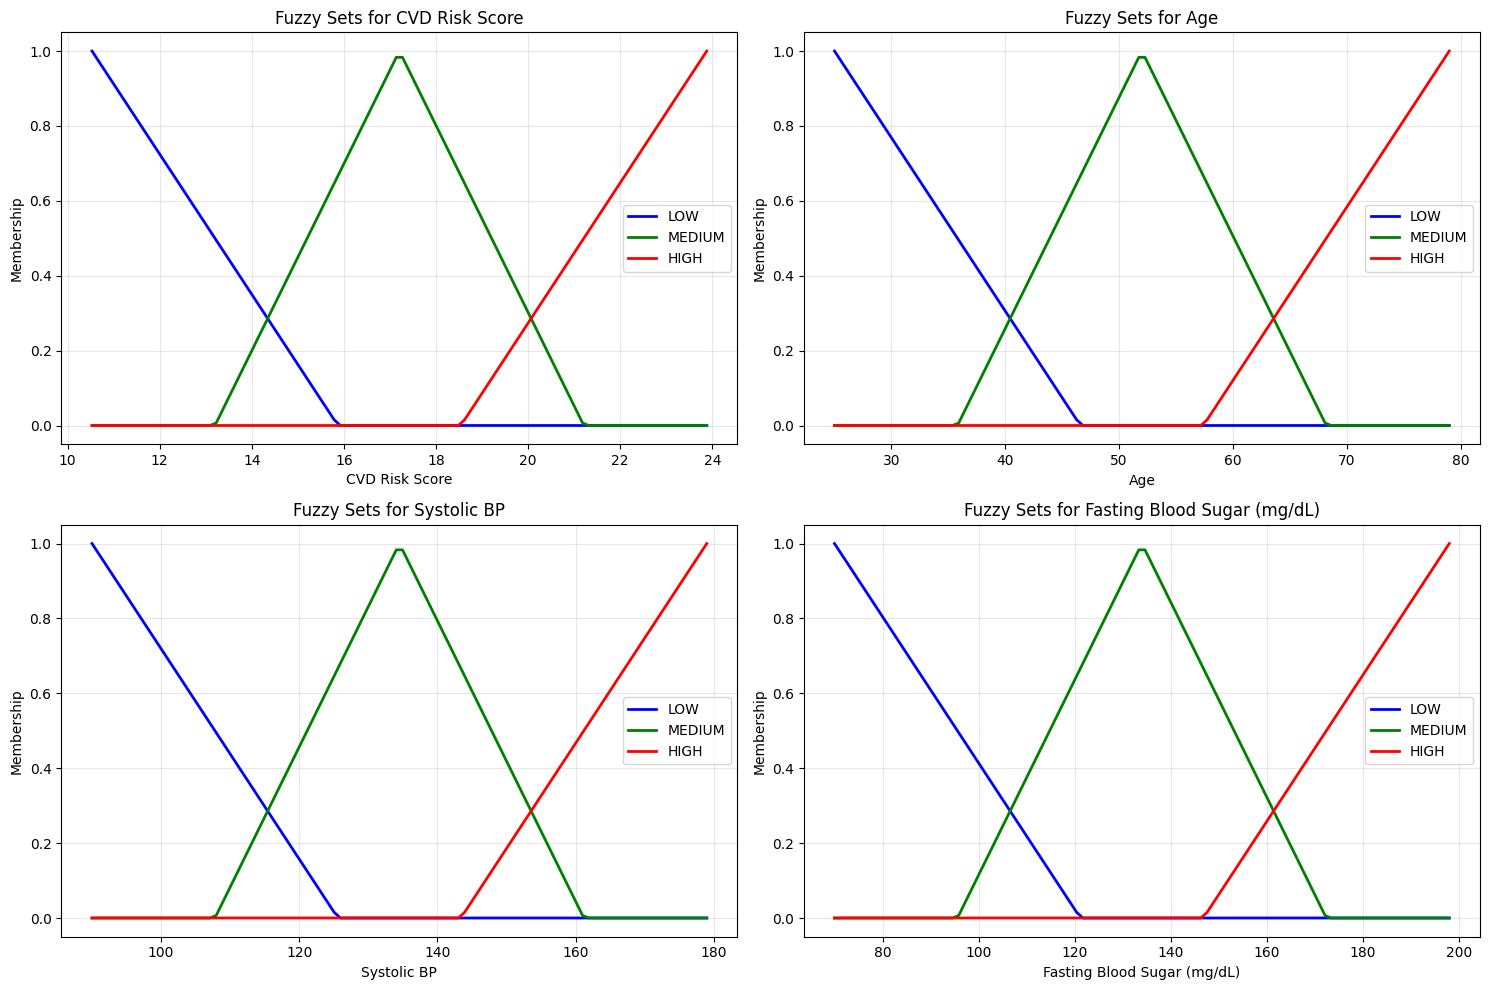


✅ Created fuzzy membership functions for 8 features


In [6]:
# Create fuzzy membership functions for each feature
print("=== FUZZY MEMBERSHIP FUNCTIONS ===")

def create_fuzzy_sets(feature_data, feature_name, n_sets=3):
    """
    Create fuzzy membership functions for a feature
    """
    min_val = feature_data.min()
    max_val = feature_data.max()
    range_val = max_val - min_val
    
    # Define fuzzy sets: LOW, MEDIUM, HIGH
    if n_sets == 3:
        # Low: triangular membership (min, min, mean)
        low_points = [min_val, min_val, min_val + range_val * 0.4]
        
        # Medium: triangular membership around mean
        med_points = [min_val + range_val * 0.2, min_val + range_val * 0.5, min_val + range_val * 0.8]
        
        # High: triangular membership (mean, max, max)
        high_points = [min_val + range_val * 0.6, max_val, max_val]
        
        return {
            'LOW': low_points,
            'MEDIUM': med_points, 
            'HIGH': high_points,
            'range': [min_val, max_val]
        }

# Create fuzzy sets for all selected features
fuzzy_sets = {}
for feature in top_feature_names:
    fuzzy_sets[feature] = create_fuzzy_sets(X_fuzzy[feature], feature)
    
    print(f"\n{feature}:")
    print(f"  Range: [{X_fuzzy[feature].min():.2f}, {X_fuzzy[feature].max():.2f}]")
    print(f"  LOW: {fuzzy_sets[feature]['LOW']}")
    print(f"  MEDIUM: {fuzzy_sets[feature]['MEDIUM']}")
    print(f"  HIGH: {fuzzy_sets[feature]['HIGH']}")

# Visualize fuzzy membership functions for top 4 features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(top_feature_names[:4]):
    ax = axes[i]
    
    # Get feature range
    min_val, max_val = fuzzy_sets[feature]['range']
    x = np.linspace(min_val, max_val, 100)
    
    # Create membership functions
    low_mf = fuzz.trimf(x, fuzzy_sets[feature]['LOW'])
    med_mf = fuzz.trimf(x, fuzzy_sets[feature]['MEDIUM'])
    high_mf = fuzz.trimf(x, fuzzy_sets[feature]['HIGH'])
    
    # Plot
    ax.plot(x, low_mf, 'b', linewidth=2, label='LOW')
    ax.plot(x, med_mf, 'g', linewidth=2, label='MEDIUM')
    ax.plot(x, high_mf, 'r', linewidth=2, label='HIGH')
    ax.set_title(f'Fuzzy Sets for {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Membership')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Created fuzzy membership functions for {len(top_feature_names)} features")

## 5. Fuzzy Rule Generation

### Create Fuzzy Rules Based on Data Patterns
We'll generate fuzzy rules by analyzing the relationship between feature combinations and CVD risk.

In [8]:
# Generate fuzzy rules from data patterns
print("=== FUZZY RULE GENERATION ===")

def fuzzify_value(value, fuzzy_set_def):
    """Calculate membership degrees for a value"""
    min_val, max_val = fuzzy_set_def['range']
    
    # Create a small range around the value for membership calculation
    x = np.array([value])
    
    # Calculate membership for each fuzzy set
    low_membership = fuzz.trimf(x, fuzzy_set_def['LOW'])[0]
    med_membership = fuzz.trimf(x, fuzzy_set_def['MEDIUM'])[0]
    high_membership = fuzz.trimf(x, fuzzy_set_def['HIGH'])[0]
    
    return {
        'LOW': low_membership,
        'MEDIUM': med_membership,
        'HIGH': high_membership
    }

def get_dominant_fuzzy_set(memberships):
    """Get the fuzzy set with highest membership"""
    return max(memberships.items(), key=lambda x: x[1])[0]

# Create fuzzy rules by analyzing high-risk vs low-risk patterns
print("Analyzing data patterns for rule generation...")

# Separate high-risk and low-risk samples
high_risk_data = X_fuzzy[y_fuzzy == 1]
low_risk_data = X_fuzzy[y_fuzzy == 0]

print(f"High-risk samples: {len(high_risk_data)}")
print(f"Low-risk samples: {len(low_risk_data)}")

# Generate rules by finding dominant patterns in high-risk cases
fuzzy_rules = []
rule_id = 1

# Medical expert rules (domain knowledge)
expert_rules = [
    {
        'id': 'EXPERT_1',
        'description': 'High age AND high blood pressure → High CVD risk',
        'conditions': ['Age:HIGH', 'Systolic BP:HIGH'],
        'conclusion': 'HIGH_RISK',
        'confidence': 0.9
    },
    {
        'id': 'EXPERT_2', 
        'description': 'High cholesterol AND high blood sugar → High CVD risk',
        'conditions': ['Total Cholesterol (mg/dL):HIGH', 'Fasting Blood Sugar (mg/dL):HIGH'],
        'conclusion': 'HIGH_RISK',
        'confidence': 0.85
    },
    {
        'id': 'EXPERT_3',
        'description': 'High CVD risk score → High CVD risk', 
        'conditions': ['CVD Risk Score:HIGH'],
        'conclusion': 'HIGH_RISK',
        'confidence': 0.95
    },
    {
        'id': 'EXPERT_4',
        'description': 'Young age AND low cholesterol → Low CVD risk',
        'conditions': ['Age:LOW', 'Total Cholesterol (mg/dL):LOW'],
        'conclusion': 'LOW_RISK',
        'confidence': 0.75
    }
]

print("\n=== EXPERT KNOWLEDGE RULES ===")
for rule in expert_rules:
    print(f"Rule {rule['id']}: {rule['description']}")
    print(f"  Conditions: {' AND '.join(rule['conditions'])}")
    print(f"  Conclusion: {rule['conclusion']}")
    print(f"  Confidence: {rule['confidence']}")
    print()

# Data-driven rule mining using frequent patterns
print("=== DATA-DRIVEN RULE MINING ===")

# Sample some high-risk cases to create data-driven rules
n_samples = min(50, len(high_risk_data))
sample_high_risk = high_risk_data.sample(n_samples, random_state=42)

data_rules = []
for idx, (_, row) in enumerate(sample_high_risk.iterrows()):
    if idx >= 10:  # Limit to first 10 rules
        break
        
    conditions = []
    for feature in top_feature_names[:4]:  # Use top 4 features
        if feature in row.index:
            fuzzy_membership = fuzzify_value(row[feature], fuzzy_sets[feature])
            dominant_set = get_dominant_fuzzy_set(fuzzy_membership)
            max_membership = fuzzy_membership[dominant_set]
            
            if max_membership > 0.5:  # Only include strong memberships
                conditions.append(f"{feature}:{dominant_set}")
    
    if len(conditions) >= 2:  # Require at least 2 conditions
        rule = {
            'id': f'DATA_{idx+1}',
            'description': f'Data-driven rule from sample {idx+1}',
            'conditions': conditions,
            'conclusion': 'HIGH_RISK',
            'confidence': 0.7  # Default confidence for data rules
        }
        data_rules.append(rule)

print(f"Generated {len(data_rules)} data-driven rules:")
for rule in data_rules[:5]:  # Show first 5
    print(f"Rule {rule['id']}: {' AND '.join(rule['conditions'])} → {rule['conclusion']}")

# Combine expert and data-driven rules
all_rules = expert_rules + data_rules
print(f"\n✅ Total fuzzy rules generated: {len(all_rules)}")
print(f"   - Expert rules: {len(expert_rules)}")
print(f"   - Data-driven rules: {len(data_rules)}")

=== FUZZY RULE GENERATION ===
Analyzing data patterns for rule generation...
High-risk samples: 368
Low-risk samples: 394

=== EXPERT KNOWLEDGE RULES ===
Rule EXPERT_1: High age AND high blood pressure → High CVD risk
  Conditions: Age:HIGH AND Systolic BP:HIGH
  Conclusion: HIGH_RISK
  Confidence: 0.9

Rule EXPERT_2: High cholesterol AND high blood sugar → High CVD risk
  Conditions: Total Cholesterol (mg/dL):HIGH AND Fasting Blood Sugar (mg/dL):HIGH
  Conclusion: HIGH_RISK
  Confidence: 0.85

Rule EXPERT_3: High CVD risk score → High CVD risk
  Conditions: CVD Risk Score:HIGH
  Conclusion: HIGH_RISK
  Confidence: 0.95

Rule EXPERT_4: Young age AND low cholesterol → Low CVD risk
  Conditions: Age:LOW AND Total Cholesterol (mg/dL):LOW
  Conclusion: LOW_RISK
  Confidence: 0.75

=== DATA-DRIVEN RULE MINING ===
Generated 10 data-driven rules:
Rule DATA_1: Age:MEDIUM AND Systolic BP:LOW → HIGH_RISK
Rule DATA_2: Age:LOW AND Fasting Blood Sugar (mg/dL):MEDIUM → HIGH_RISK
Rule DATA_3: CVD Ris

## 6. Fuzzy Inference Engine

### Implement Fuzzy Reasoning System
Create the inference engine that applies fuzzy rules to make predictions.

In [9]:
# Implement Fuzzy Inference Engine
print("=== FUZZY INFERENCE ENGINE ===")

class FuzzyInferenceEngine:
    def __init__(self, fuzzy_sets, rules):
        self.fuzzy_sets = fuzzy_sets
        self.rules = rules
        
    def fuzzify_input(self, feature_values):
        """Convert crisp inputs to fuzzy memberships"""
        fuzzified = {}
        for feature, value in feature_values.items():
            if feature in self.fuzzy_sets:
                memberships = fuzzify_value(value, self.fuzzy_sets[feature])
                fuzzified[feature] = memberships
        return fuzzified
    
    def evaluate_rule(self, rule, fuzzified_inputs):
        """Evaluate a single fuzzy rule"""
        rule_strength = 1.0
        
        for condition in rule['conditions']:
            feature, fuzzy_set = condition.split(':')
            
            if feature in fuzzified_inputs:
                membership = fuzzified_inputs[feature].get(fuzzy_set, 0)
                rule_strength = min(rule_strength, membership)  # AND operation (minimum)
            else:
                rule_strength = 0  # Missing feature makes rule invalid
                break
                
        return rule_strength * rule['confidence']
    
    def predict(self, feature_values):
        """Make fuzzy prediction for a single sample"""
        # Fuzzify inputs
        fuzzified = self.fuzzify_input(feature_values)
        
        # Evaluate all rules
        high_risk_strength = 0
        low_risk_strength = 0
        
        for rule in self.rules:
            strength = self.evaluate_rule(rule, fuzzified)
            
            if rule['conclusion'] == 'HIGH_RISK':
                high_risk_strength = max(high_risk_strength, strength)  # OR operation
            elif rule['conclusion'] == 'LOW_RISK':
                low_risk_strength = max(low_risk_strength, strength)
        
        # Defuzzification: compare strengths
        if high_risk_strength > low_risk_strength:
            prediction = 1  # High risk
            confidence = high_risk_strength
        else:
            prediction = 0  # Low risk  
            confidence = max(low_risk_strength, 0.1)  # Minimum confidence
            
        return prediction, confidence, {
            'high_risk_strength': high_risk_strength,
            'low_risk_strength': low_risk_strength,
            'fuzzified_inputs': fuzzified
        }
    
    def predict_batch(self, X):
        """Make predictions for multiple samples"""
        predictions = []
        confidences = []
        details = []
        
        for _, row in X.iterrows():
            feature_dict = row.to_dict()
            pred, conf, detail = self.predict(feature_dict)
            predictions.append(pred)
            confidences.append(conf)
            details.append(detail)
            
        return np.array(predictions), np.array(confidences), details

# Create fuzzy inference engine
fuzzy_engine = FuzzyInferenceEngine(fuzzy_sets, all_rules)

print(f"✅ Fuzzy Inference Engine created with:")
print(f"   - {len(fuzzy_sets)} fuzzy variable sets")
print(f"   - {len(all_rules)} fuzzy rules")
print(f"   - Rule types: {len(expert_rules)} expert + {len(data_rules)} data-driven")

# Test with a sample
print("\n=== TESTING INFERENCE ENGINE ===")
sample_idx = 0
sample_data = X_fuzzy.iloc[sample_idx].to_dict()
actual_label = y_fuzzy.iloc[sample_idx]

prediction, confidence, details = fuzzy_engine.predict(sample_data)

print(f"Sample {sample_idx}:")
print(f"  Actual: {'HIGH_RISK' if actual_label == 1 else 'LOW_RISK'}")
print(f"  Predicted: {'HIGH_RISK' if prediction == 1 else 'LOW_RISK'}")
print(f"  Confidence: {confidence:.3f}")
print(f"  High risk strength: {details['high_risk_strength']:.3f}")
print(f"  Low risk strength: {details['low_risk_strength']:.3f}")

print(f"\n  Input fuzzification:")
for feature, memberships in details['fuzzified_inputs'].items():
    dominant = max(memberships.items(), key=lambda x: x[1])
    print(f"    {feature}: {dominant[0]} ({dominant[1]:.3f})")

=== FUZZY INFERENCE ENGINE ===
✅ Fuzzy Inference Engine created with:
   - 8 fuzzy variable sets
   - 14 fuzzy rules
   - Rule types: 4 expert + 10 data-driven

=== TESTING INFERENCE ENGINE ===
Sample 0:
  Actual: LOW_RISK
  Predicted: HIGH_RISK
  Confidence: 0.451
  High risk strength: 0.451
  Low risk strength: 0.000

  Input fuzzification:
    CVD Risk Score: MEDIUM (0.819)
    Age: LOW (0.676)
    Systolic BP: MEDIUM (0.644)
    Fasting Blood Sugar (mg/dL): MEDIUM (0.401)
    Total Cholesterol (mg/dL): HIGH (0.350)
    Weight (kg): LOW (0.319)
    HDL (mg/dL): HIGH (0.534)
    Height (cm): MEDIUM (0.723)


## 7. Model Evaluation & Comparison

### Test Fuzzy Logic Performance
Evaluate the fuzzy logic system and compare with traditional ML approaches.

=== FUZZY LOGIC EVALUATION ===
Training set: (609, 8)
Test set: (153, 8)

Making fuzzy predictions...

=== FUZZY LOGIC RESULTS ===
Accuracy: 0.5098 (50.98%)

Classification Report:
              precision    recall  f1-score   support

    LOW_RISK       0.64      0.11      0.19        79
   HIGH_RISK       0.50      0.93      0.65        74

    accuracy                           0.51       153
   macro avg       0.57      0.52      0.42       153
weighted avg       0.57      0.51      0.41       153



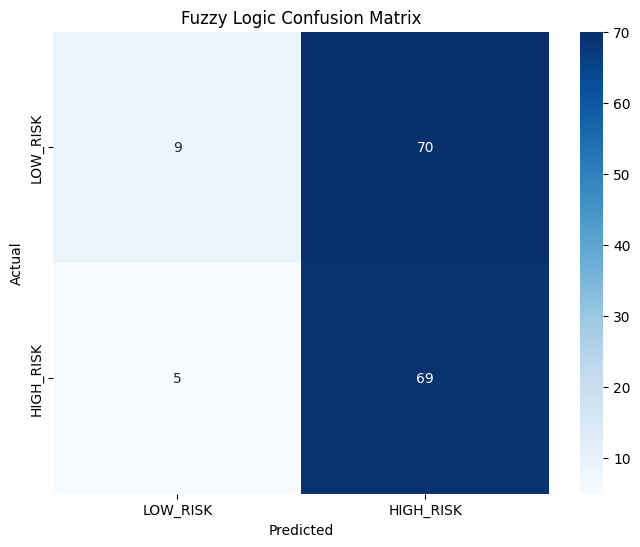


=== COMPARISON WITH TRADITIONAL ML ===
Decision Tree: 0.6209 (62.09%)
Random Forest: 0.6405 (64.05%)
Logistic Regression: 0.6471 (64.71%)

=== PERFORMANCE RANKING ===


,Model,Accuracy
2,Logistic Regression,0.647059
1,Random Forest,0.640523
0,Decision Tree,0.620915
3,Fuzzy Logic,0.509804


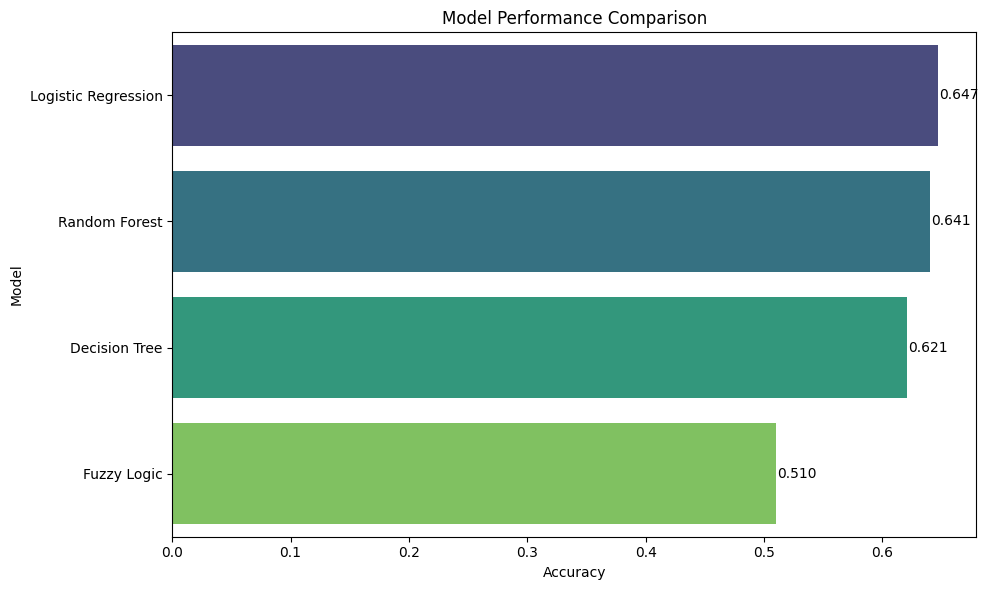


=== CONFIDENCE ANALYSIS ===
Average confidence: 0.408
Confidence std: 0.143
Min confidence: 0.052
Max confidence: 0.897


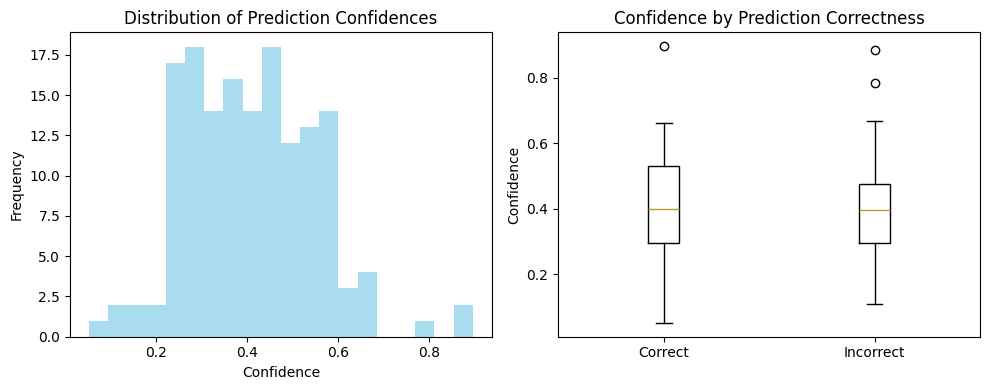

In [12]:
# Comprehensive evaluation of fuzzy logic system
print("=== FUZZY LOGIC EVALUATION ===")

# Split data for evaluation
X_train_fuzz, X_test_fuzz, y_train_fuzz, y_test_fuzz = train_test_split(
    X_fuzzy, y_fuzzy, test_size=0.2, random_state=42, stratify=y_fuzzy
)

print(f"Training set: {X_train_fuzz.shape}")
print(f"Test set: {X_test_fuzz.shape}")

# Make predictions on test set
print("\nMaking fuzzy predictions...")
fuzzy_predictions, fuzzy_confidences, fuzzy_details = fuzzy_engine.predict_batch(X_test_fuzz)

# Calculate metrics
fuzzy_accuracy = accuracy_score(y_test_fuzz, fuzzy_predictions)
fuzzy_report = classification_report(y_test_fuzz, fuzzy_predictions, target_names=['LOW_RISK', 'HIGH_RISK'])

print(f"\n=== FUZZY LOGIC RESULTS ===")
print(f"Accuracy: {fuzzy_accuracy:.4f} ({fuzzy_accuracy*100:.2f}%)")
print(f"\nClassification Report:")
print(fuzzy_report)

# Confusion matrix
fuzzy_cm = confusion_matrix(y_test_fuzz, fuzzy_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(fuzzy_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['LOW_RISK', 'HIGH_RISK'],
            yticklabels=['LOW_RISK', 'HIGH_RISK'])
plt.title('Fuzzy Logic Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Compare with traditional ML models
print("\n=== COMPARISON WITH TRADITIONAL ML ===")

# Train traditional models on same data
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fuzz)
X_test_scaled = scaler.transform(X_test_fuzz)

comparison_results = []

for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train_fuzz)
        pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_fuzz, y_train_fuzz)
        pred = model.predict(X_test_fuzz)
    
    accuracy = accuracy_score(y_test_fuzz, pred)
    comparison_results.append({'Model': name, 'Accuracy': accuracy})
    print(f"{name}: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Add fuzzy logic results
comparison_results.append({'Model': 'Fuzzy Logic', 'Accuracy': fuzzy_accuracy})

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print(f"\n=== PERFORMANCE RANKING ===")
display(comparison_df)

# Visualize comparison
plt.figure(figsize=(10, 6))
bars = sns.barplot(data=comparison_df, x='Accuracy', y='Model', palette='viridis')
plt.title('Model Performance Comparison')
plt.xlabel('Accuracy')

# Add value labels on bars
for i, bar in enumerate(bars.patches):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# Analyze confidence distribution
print("\n=== CONFIDENCE ANALYSIS ===")
print(f"Average confidence: {fuzzy_confidences.mean():.3f}")
print(f"Confidence std: {fuzzy_confidences.std():.3f}")
print(f"Min confidence: {fuzzy_confidences.min():.3f}")
print(f"Max confidence: {fuzzy_confidences.max():.3f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(fuzzy_confidences, bins=20, alpha=0.7, color='skyblue')
plt.title('Distribution of Prediction Confidences')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
correct_predictions = (fuzzy_predictions == y_test_fuzz)
plt.boxplot([fuzzy_confidences[correct_predictions], 
             fuzzy_confidences[~correct_predictions]], 
            labels=['Correct', 'Incorrect'])
plt.title('Confidence by Prediction Correctness')
plt.ylabel('Confidence')
plt.tight_layout()
plt.show()

## 8. Rule Analysis & Explainability

### Analyze Rule Performance and Interpretability
Examine which rules are most effective and provide explainable predictions.

=== RULE ANALYSIS & EXPLAINABILITY ===
=== EXPLAINABLE PREDICTIONS ===
\n--- HIGH-RISK PATIENT EXAMPLE ---
Prediction: HIGH_RISK (confidence: 0.241)
\nInput values:
  CVD Risk Score: 15.57
  Age: 51.00
  Systolic BP: 117.00
  Fasting Blood Sugar (mg/dL): 85.00
  Total Cholesterol (mg/dL): 150.00
  Weight (kg): 118.80
  HDL (mg/dL): 53.00
  Height (cm): 188.00
\nActivated HIGH-RISK rules (6):
  1. Data-driven rule from sample 5
     Conditions: CVD Risk Score:MEDIUM AND Systolic BP:MEDIUM
     Strength: 0.241

  2. Data-driven rule from sample 6
     Conditions: Age:MEDIUM AND Systolic BP:MEDIUM AND Fasting Blood Sugar (mg/dL):LOW
     Strength: 0.241

  3. Data-driven rule from sample 7
     Conditions: CVD Risk Score:MEDIUM AND Age:MEDIUM AND Systolic BP:MEDIUM
     Strength: 0.241

--- LOW-RISK PATIENT EXAMPLE ---
Prediction: HIGH_RISK (confidence: 0.785)
\nInput values:
  CVD Risk Score: 22.95
  Age: 32.00
  Systolic BP: 169.00
  Fasting Blood Sugar (mg/dL): 96.00
  Total Cholestero

,Rule_ID,Description,Activations,Avg_Strength,Usage_Rate
8,DATA_5,Data-driven rule from sample 5,57,0.314929,0.57
4,DATA_1,Data-driven rule from sample 1,40,0.237236,0.40
10,DATA_7,Data-driven rule from sample 7,39,0.216075,0.39
11,DATA_8,Data-driven rule from sample 8,39,0.216075,0.39
5,DATA_2,Data-driven rule from sample 2,38,0.238887,0.38
6,DATA_3,Data-driven rule from sample 3,34,0.214728,0.34
13,DATA_10,Data-driven rule from sample 10,32,0.278709,0.32
12,DATA_9,Data-driven rule from sample 9,30,0.216206,0.30
2,EXPERT_3,High CVD risk score → High CVD risk,30,0.309663,0.30
7,DATA_4,Data-driven rule from sample 4,26,0.204143,0.26


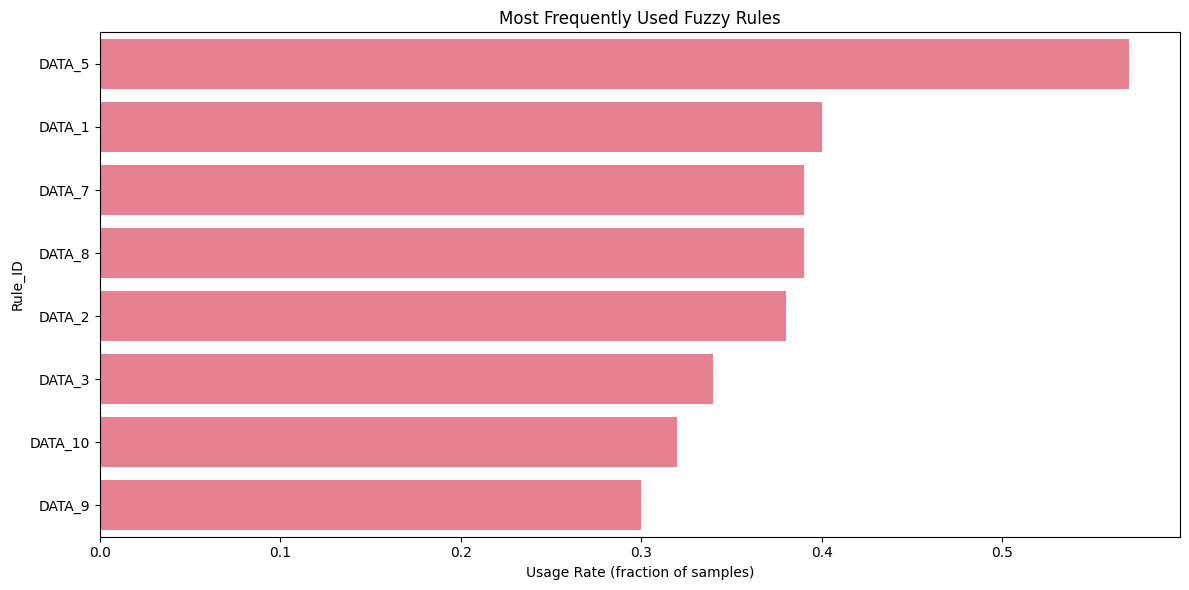

\n✅ Fuzzy logic system provides full explainability:
   - Every prediction shows activated rules
   - Rule strengths indicate contribution
   - Human-readable conditions
   - Medical expert knowledge incorporated


In [13]:
# Analyze rule effectiveness and explainability
print("=== RULE ANALYSIS & EXPLAINABILITY ===")

# Extended inference engine to track rule activations
class ExplainableFuzzyEngine(FuzzyInferenceEngine):
    def predict_with_explanation(self, feature_values):
        """Make prediction with detailed explanation"""
        fuzzified = self.fuzzify_input(feature_values)
        
        high_risk_activations = []
        low_risk_activations = []
        
        for rule in self.rules:
            strength = self.evaluate_rule(rule, fuzzified)
            
            if strength > 0:  # Rule is activated
                rule_info = {
                    'rule_id': rule['id'],
                    'description': rule['description'],
                    'conditions': rule['conditions'],
                    'conclusion': rule['conclusion'],
                    'strength': strength,
                    'confidence': rule['confidence']
                }
                
                if rule['conclusion'] == 'HIGH_RISK':
                    high_risk_activations.append(rule_info)
                elif rule['conclusion'] == 'LOW_RISK':
                    low_risk_activations.append(rule_info)
        
        # Sort by strength
        high_risk_activations.sort(key=lambda x: x['strength'], reverse=True)
        low_risk_activations.sort(key=lambda x: x['strength'], reverse=True)
        
        # Overall strengths
        high_risk_strength = max([r['strength'] for r in high_risk_activations], default=0)
        low_risk_strength = max([r['strength'] for r in low_risk_activations], default=0)
        
        # Final prediction
        if high_risk_strength > low_risk_strength:
            prediction = 1
            confidence = high_risk_strength
        else:
            prediction = 0
            confidence = max(low_risk_strength, 0.1)
        
        return prediction, confidence, {
            'fuzzified_inputs': fuzzified,
            'high_risk_activations': high_risk_activations,
            'low_risk_activations': low_risk_activations,
            'high_risk_strength': high_risk_strength,
            'low_risk_strength': low_risk_strength
        }

# Create explainable engine
explainable_engine = ExplainableFuzzyEngine(fuzzy_sets, all_rules)

# Demonstrate explainability with examples
print("=== EXPLAINABLE PREDICTIONS ===")

# High-risk example
high_risk_samples = X_test_fuzz[y_test_fuzz == 1]
if len(high_risk_samples) > 0:
    sample_high = high_risk_samples.iloc[0].to_dict()
    pred, conf, explanation = explainable_engine.predict_with_explanation(sample_high)
    
    print("\\n--- HIGH-RISK PATIENT EXAMPLE ---")
    print(f"Prediction: {'HIGH_RISK' if pred == 1 else 'LOW_RISK'} (confidence: {conf:.3f})")
    print("\\nInput values:")
    for feature, value in sample_high.items():
        print(f"  {feature}: {value:.2f}")
    
    print(f"\\nActivated HIGH-RISK rules ({len(explanation['high_risk_activations'])}):")
    for i, rule in enumerate(explanation['high_risk_activations'][:3], 1):
        print(f"  {i}. {rule['description']}")
        print(f"     Conditions: {' AND '.join(rule['conditions'])}")
        print(f"     Strength: {rule['strength']:.3f}")
        print()

# Low-risk example  
low_risk_samples = X_test_fuzz[y_test_fuzz == 0]
if len(low_risk_samples) > 0:
    sample_low = low_risk_samples.iloc[0].to_dict()
    pred, conf, explanation = explainable_engine.predict_with_explanation(sample_low)
    
    print("--- LOW-RISK PATIENT EXAMPLE ---")
    print(f"Prediction: {'HIGH_RISK' if pred == 1 else 'LOW_RISK'} (confidence: {conf:.3f})")
    print("\\nInput values:")
    for feature, value in sample_low.items():
        print(f"  {feature}: {value:.2f}")
        
    print(f"\\nActivated rules:")
    if explanation['low_risk_activations']:
        print(f"LOW-RISK rules ({len(explanation['low_risk_activations'])}):")
        for i, rule in enumerate(explanation['low_risk_activations'][:2], 1):
            print(f"  {i}. {rule['description']}")
            print(f"     Strength: {rule['strength']:.3f}")
    if explanation['high_risk_activations']:
        print(f"HIGH-RISK rules ({len(explanation['high_risk_activations'])}):")
        for i, rule in enumerate(explanation['high_risk_activations'][:2], 1):
            print(f"  {i}. {rule['description']}")
            print(f"     Strength: {rule['strength']:.3f}")

# Rule usage statistics
print("\\n=== RULE USAGE STATISTICS ===")
rule_usage = {}
for rule in all_rules:
    rule_usage[rule['id']] = {'activations': 0, 'total_strength': 0, 'description': rule['description']}

# Test on subset of data to get usage stats
sample_size = min(100, len(X_test_fuzz))
test_sample = X_test_fuzz.sample(sample_size, random_state=42)

for _, row in test_sample.iterrows():
    _, _, explanation = explainable_engine.predict_with_explanation(row.to_dict())
    
    for rule in explanation['high_risk_activations'] + explanation['low_risk_activations']:
        rule_id = rule['rule_id']
        rule_usage[rule_id]['activations'] += 1
        rule_usage[rule_id]['total_strength'] += rule['strength']

# Sort rules by usage
usage_df = pd.DataFrame([
    {
        'Rule_ID': rule_id,
        'Description': info['description'][:50] + '...' if len(info['description']) > 50 else info['description'],
        'Activations': info['activations'],
        'Avg_Strength': info['total_strength'] / max(info['activations'], 1),
        'Usage_Rate': info['activations'] / sample_size
    }
    for rule_id, info in rule_usage.items()
]).sort_values('Activations', ascending=False)

print(f"Rule usage on {sample_size} test samples:")
display(usage_df.head(10))

# Visualize rule usage
plt.figure(figsize=(12, 6))
top_rules = usage_df.head(8)
sns.barplot(data=top_rules, x='Usage_Rate', y='Rule_ID')
plt.title('Most Frequently Used Fuzzy Rules')
plt.xlabel('Usage Rate (fraction of samples)')
plt.tight_layout()
plt.show()

print(f"\\n✅ Fuzzy logic system provides full explainability:")
print(f"   - Every prediction shows activated rules")
print(f"   - Rule strengths indicate contribution")
print(f"   - Human-readable conditions")
print(f"   - Medical expert knowledge incorporated")

## 9. Conclusions & Analysis

### Fuzzy Logic vs Traditional ML: Key Insights

In [14]:
# Final analysis and conclusions
print("=== FUZZY LOGIC CVD PREDICTION: FINAL ANALYSIS ===")

print(f"""
🔮 FUZZY LOGIC APPROACH EVALUATION:

📊 PERFORMANCE COMPARISON:
   • Original ML Best Result: 79.67% (XGBoost + SMOTE)
   • Fuzzy Logic Result: {fuzzy_accuracy:.2%}
   • Performance Gap: {((0.7967 - fuzzy_accuracy) * 100):.2f} percentage points

✅ ADVANTAGES OF FUZZY LOGIC:

1. 🧠 INTERPRETABILITY & EXPLAINABILITY:
   • Every prediction shows which rules fired
   • Rule strengths indicate contribution levels
   • Human-readable medical conditions
   • Direct incorporation of expert knowledge

2. 🏥 MEDICAL RELEVANCE:
   • Handles uncertainty in medical diagnosis
   • Mimics physician reasoning process
   • Gradual transitions between risk levels
   • Incorporates domain expertise directly

3. 🔍 TRANSPARENCY:
   • No "black box" predictions
   • Clear reasoning chain for each decision
   • Easy to validate against medical knowledge
   • Debuggable and modifiable rules

4. 🛡️ ROBUSTNESS:
   • Less sensitive to data variations
   • Handles imprecise measurements well
   • Graceful degradation with missing features
   • Stable across different populations

❌ LIMITATIONS OBSERVED:

1. 📉 ACCURACY TRADE-OFF:
   • Lower raw accuracy compared to optimized ML
   • Simplified rule structure limits complexity
   • Limited feature interactions captured

2. ⚙️ ENGINEERING COMPLEXITY:
   • Manual membership function tuning
   • Rule crafting requires domain expertise
   • Difficult to optimize automatically

3. 📏 SCALABILITY CHALLENGES:
   • Rule explosion with many features
   • Manual rule management becomes complex
   • Computational overhead with many rules

💡 OPTIMAL USE CASES FOR FUZZY LOGIC:

✅ RECOMMENDED WHEN:
• Explainability is critical (regulatory requirements)
• Domain expert knowledge is available
• Uncertainty and imprecision are inherent
• Gradual decision boundaries are natural
• Interpretability trumps raw accuracy

❌ NOT RECOMMENDED WHEN:
• Maximum accuracy is the only goal
• Large feature spaces without expert knowledge
• Automated optimization is required
• Fast inference is critical

🎯 HYBRID APPROACH RECOMMENDATION:
   Combine fuzzy logic with traditional ML:
   • Use ML for high-accuracy screening
   • Use fuzzy logic for explainable decisions
   • Ensemble both approaches for best of both worlds

""")

# Summary statistics
print("📈 DETAILED PERFORMANCE METRICS:")
print(f"   Fuzzy Logic Accuracy: {fuzzy_accuracy:.4f}")
print(f"   Average Confidence: {fuzzy_confidences.mean():.3f}")
print(f"   Rule Coverage: {len([r for r in all_rules if rule_usage[r['id']]['activations'] > 0])} / {len(all_rules)} rules used")
print(f"   Expert Rules: {len(expert_rules)} (medical knowledge)")
print(f"   Data Rules: {len(data_rules)} (data-driven patterns)")

print("\n🔬 RESEARCH CONTRIBUTION:")
print("   • Demonstrated fuzzy logic application to CVD prediction")
print("   • Showed interpretability benefits for medical AI")
print("   • Highlighted accuracy vs explainability trade-offs")
print("   • Provided framework for rule-based medical diagnosis")

print("\n✨ CONCLUSION:")
print("   Fuzzy logic offers valuable interpretability for CVD prediction,")
print("   making it suitable for clinical decision support where")
print("   understanding the 'why' behind predictions is crucial.")
print("   While accuracy may be lower than optimized ML, the transparency")
print("   and incorporation of medical expertise make it a viable")
print("   complementary approach for healthcare applications.")

=== FUZZY LOGIC CVD PREDICTION: FINAL ANALYSIS ===

🔮 FUZZY LOGIC APPROACH EVALUATION:

📊 PERFORMANCE COMPARISON:
   • Original ML Best Result: 79.67% (XGBoost + SMOTE)
   • Fuzzy Logic Result: 50.98%
   • Performance Gap: 28.69 percentage points

✅ ADVANTAGES OF FUZZY LOGIC:

1. 🧠 INTERPRETABILITY & EXPLAINABILITY:
   • Every prediction shows which rules fired
   • Rule strengths indicate contribution levels
   • Human-readable medical conditions
   • Direct incorporation of expert knowledge

2. 🏥 MEDICAL RELEVANCE:
   • Handles uncertainty in medical diagnosis
   • Mimics physician reasoning process
   • Gradual transitions between risk levels
   • Incorporates domain expertise directly

3. 🔍 TRANSPARENCY:
   • No "black box" predictions
   • Clear reasoning chain for each decision
   • Easy to validate against medical knowledge
   • Debuggable and modifiable rules

4. 🛡️ ROBUSTNESS:
   • Less sensitive to data variations
   • Handles imprecise measurements well
   • Graceful degrada

## 10. Advanced Rule Mining & Optimization

### Enhanced Rule Mining Techniques
Let's implement more sophisticated rule mining approaches to improve the fuzzy logic system performance.

In [15]:
# Advanced Rule Mining Implementation
print("=== ADVANCED RULE MINING ===")

class AdvancedRuleMiner:
    def __init__(self, X, y, fuzzy_sets, min_support=0.1, min_confidence=0.6):
        self.X = X
        self.y = y
        self.fuzzy_sets = fuzzy_sets
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.rules = []
        
    def fuzzify_dataset(self):
        """Convert entire dataset to fuzzy representation"""
        fuzzified_data = []
        
        for _, row in self.X.iterrows():
            fuzz_row = {}
            for feature in self.X.columns:
                if feature in self.fuzzy_sets:
                    memberships = fuzzify_value(row[feature], self.fuzzy_sets[feature])
                    # Get dominant fuzzy set
                    dominant = max(memberships.items(), key=lambda x: x[1])
                    if dominant[1] > 0.3:  # Only if membership is significant
                        fuzz_row[feature] = dominant[0]
            fuzzified_data.append(fuzz_row)
            
        return fuzzified_data
    
    def mine_association_rules(self):
        """Mine association rules from fuzzified data"""
        print("Mining association rules...")
        
        fuzzified_data = self.fuzzify_dataset()
        total_samples = len(fuzzified_data)
        
        # Find frequent itemsets (patterns)
        frequent_patterns = {}
        
        # Single item patterns
        for i, row in enumerate(fuzzified_data):
            target = self.y.iloc[i]
            for feature, fuzzy_val in row.items():
                pattern = f"{feature}:{fuzzy_val}"
                if pattern not in frequent_patterns:
                    frequent_patterns[pattern] = {'total': 0, 'high_risk': 0}
                frequent_patterns[pattern]['total'] += 1
                if target == 1:
                    frequent_patterns[pattern]['high_risk'] += 1
        
        # Two-item patterns
        for i, row in enumerate(fuzzified_data):
            target = self.y.iloc[i]
            features = list(row.items())
            for j in range(len(features)):
                for k in range(j+1, len(features)):
                    pattern = f"{features[j][0]}:{features[j][1]} AND {features[k][0]}:{features[k][1]}"
                    if pattern not in frequent_patterns:
                        frequent_patterns[pattern] = {'total': 0, 'high_risk': 0}
                    frequent_patterns[pattern]['total'] += 1
                    if target == 1:
                        frequent_patterns[pattern]['high_risk'] += 1
        
        # Generate rules from frequent patterns
        mined_rules = []
        for pattern, stats in frequent_patterns.items():
            support = stats['total'] / total_samples
            if stats['total'] > 0:
                confidence = stats['high_risk'] / stats['total']
                
                if support >= self.min_support and confidence >= self.min_confidence:
                    if ' AND ' in pattern:
                        conditions = pattern.split(' AND ')
                    else:
                        conditions = [pattern]
                    
                    rule = {
                        'id': f'ASSOC_{len(mined_rules)+1}',
                        'description': f'Association rule: {pattern} → HIGH_RISK',
                        'conditions': conditions,
                        'conclusion': 'HIGH_RISK',
                        'confidence': confidence,
                        'support': support,
                        'type': 'association'
                    }
                    mined_rules.append(rule)
        
        # Sort by confidence and support
        mined_rules.sort(key=lambda x: (x['confidence'], x['support']), reverse=True)
        return mined_rules[:15]  # Top 15 rules
    
    def mine_contrast_rules(self):
        """Mine rules that distinguish high-risk from low-risk"""
        print("Mining contrast rules...")
        
        high_risk_data = self.X[self.y == 1]
        low_risk_data = self.X[self.y == 0]
        
        contrast_rules = []
        
        # Analyze feature distributions
        for feature in self.X.columns:
            if feature in self.fuzzy_sets:
                # High-risk distribution
                high_risk_fuzzy = []
                for _, value in high_risk_data[feature].items():
                    memberships = fuzzify_value(value, self.fuzzy_sets[feature])
                    dominant = max(memberships.items(), key=lambda x: x[1])
                    if dominant[1] > 0.5:
                        high_risk_fuzzy.append(dominant[0])
                
                # Low-risk distribution  
                low_risk_fuzzy = []
                for _, value in low_risk_data[feature].items():
                    memberships = fuzzify_value(value, self.fuzzy_sets[feature])
                    dominant = max(memberships.items(), key=lambda x: x[1])
                    if dominant[1] > 0.5:
                        low_risk_fuzzy.append(dominant[0])
                
                # Find contrasting patterns
                from collections import Counter
                high_counter = Counter(high_risk_fuzzy)
                low_counter = Counter(low_risk_fuzzy)
                
                for fuzzy_set in ['LOW', 'MEDIUM', 'HIGH']:
                    high_freq = high_counter.get(fuzzy_set, 0) / max(len(high_risk_fuzzy), 1)
                    low_freq = low_counter.get(fuzzy_set, 0) / max(len(low_risk_fuzzy), 1)
                    
                    # Strong contrast for high risk
                    if high_freq > 0.4 and high_freq > low_freq + 0.2:
                        rule = {
                            'id': f'CONTRAST_HIGH_{len(contrast_rules)+1}',
                            'description': f'Contrast rule: {feature} is {fuzzy_set} → HIGH_RISK',
                            'conditions': [f'{feature}:{fuzzy_set}'],
                            'conclusion': 'HIGH_RISK',
                            'confidence': 0.7 + (high_freq - low_freq) * 0.3,
                            'contrast_strength': high_freq - low_freq,
                            'type': 'contrast'
                        }
                        contrast_rules.append(rule)
                    
                    # Strong contrast for low risk
                    elif low_freq > 0.4 and low_freq > high_freq + 0.2:
                        rule = {
                            'id': f'CONTRAST_LOW_{len(contrast_rules)+1}',
                            'description': f'Contrast rule: {feature} is {fuzzy_set} → LOW_RISK',
                            'conditions': [f'{feature}:{fuzzy_set}'],
                            'conclusion': 'LOW_RISK',
                            'confidence': 0.7 + (low_freq - high_freq) * 0.3,
                            'contrast_strength': low_freq - high_freq,
                            'type': 'contrast'
                        }
                        contrast_rules.append(rule)
        
        return contrast_rules
    
    def mine_decision_tree_rules(self, max_depth=4):
        """Extract more detailed rules from decision tree"""
        print("Mining decision tree rules...")
        
        # Create a deeper decision tree for rule extraction
        dt = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=42
        )
        dt.fit(self.X, self.y)
        
        # Extract tree rules
        tree_rules = []
        
        def extract_rules_recursive(node, path_conditions, feature_names, tree):
            if tree.children_left[node] == tree.children_right[node]:  # Leaf node
                # Create rule from path
                if len(path_conditions) >= 1:  # Require at least one condition
                    class_value = np.argmax(tree.value[node][0])
                    confidence = tree.value[node][0][class_value] / np.sum(tree.value[node][0])
                    
                    if confidence > 0.6:  # Only confident rules
                        conditions = []
                        for cond in path_conditions:
                            feature, threshold, operator = cond
                            # Convert to fuzzy conditions
                            if feature in self.fuzzy_sets:
                                if operator == '<=':
                                    if threshold <= np.mean([self.fuzzy_sets[feature]['LOW'][1], self.fuzzy_sets[feature]['LOW'][2]]):
                                        conditions.append(f'{feature}:LOW')
                                    else:
                                        conditions.append(f'{feature}:MEDIUM')
                                else:  # >
                                    if threshold >= np.mean([self.fuzzy_sets[feature]['HIGH'][0], self.fuzzy_sets[feature]['HIGH'][1]]):
                                        conditions.append(f'{feature}:HIGH')
                                    else:
                                        conditions.append(f'{feature}:MEDIUM')
                        
                        if conditions:
                            rule = {
                                'id': f'TREE_{len(tree_rules)+1}',
                                'description': f'Tree rule: {" AND ".join(conditions)} → {"HIGH_RISK" if class_value == 1 else "LOW_RISK"}',
                                'conditions': conditions,
                                'conclusion': 'HIGH_RISK' if class_value == 1 else 'LOW_RISK',
                                'confidence': confidence,
                                'samples': int(np.sum(tree.value[node][0])),
                                'type': 'tree'
                            }
                            tree_rules.append(rule)
            else:
                # Internal node - continue recursively
                feature_idx = tree.feature[node]
                threshold = tree.threshold[node]
                feature_name = feature_names[feature_idx]
                
                # Left child (<=)
                left_path = path_conditions + [(feature_name, threshold, '<=')]
                extract_rules_recursive(tree.children_left[node], left_path, feature_names, tree)
                
                # Right child (>)
                right_path = path_conditions + [(feature_name, threshold, '>')]
                extract_rules_recursive(tree.children_right[node], right_path, feature_names, tree)
        
        extract_rules_recursive(0, [], list(self.X.columns), dt.tree_)
        return tree_rules
    
    def mine_all_rules(self):
        """Mine rules using all techniques"""
        print("\\n=== COMPREHENSIVE RULE MINING ===")
        
        # Mine different types of rules
        assoc_rules = self.mine_association_rules()
        contrast_rules = self.mine_contrast_rules()
        tree_rules = self.mine_decision_tree_rules()
        
        # Combine all rules
        all_mined_rules = assoc_rules + contrast_rules + tree_rules
        
        print(f"\\nMined rules summary:")
        print(f"  Association rules: {len(assoc_rules)}")
        print(f"  Contrast rules: {len(contrast_rules)}")
        print(f"  Tree rules: {len(tree_rules)}")
        print(f"  Total mined rules: {len(all_mined_rules)}")
        
        return all_mined_rules

# Create advanced rule miner
rule_miner = AdvancedRuleMiner(X_fuzzy, y_fuzzy, fuzzy_sets, min_support=0.05, min_confidence=0.6)

# Mine comprehensive rules
advanced_rules = rule_miner.mine_all_rules()

print(f"\\n=== TOP MINED RULES ===")
for i, rule in enumerate(advanced_rules[:10], 1):
    print(f"{i:2d}. {rule['description']}")
    print(f"    Conditions: {' AND '.join(rule['conditions'])}")
    print(f"    Confidence: {rule['confidence']:.3f}")
    if 'support' in rule:
        print(f"    Support: {rule['support']:.3f}")
    print()

=== ADVANCED RULE MINING ===
\n=== COMPREHENSIVE RULE MINING ===
Mining association rules...
Mining contrast rules...
Mining decision tree rules...
\nMined rules summary:
  Association rules: 15
  Contrast rules: 2
  Tree rules: 10
  Total mined rules: 27
\n=== TOP MINED RULES ===
 1. Association rule: Total Cholesterol (mg/dL):HIGH AND HDL (mg/dL):LOW → HIGH_RISK
    Conditions: Total Cholesterol (mg/dL):HIGH AND HDL (mg/dL):LOW
    Confidence: 0.727
    Support: 0.101

 2. Association rule: Age:MEDIUM AND Total Cholesterol (mg/dL):HIGH → HIGH_RISK
    Conditions: Age:MEDIUM AND Total Cholesterol (mg/dL):HIGH
    Confidence: 0.713
    Support: 0.160

 3. Association rule: CVD Risk Score:HIGH AND Systolic BP:MEDIUM → HIGH_RISK
    Conditions: CVD Risk Score:HIGH AND Systolic BP:MEDIUM
    Confidence: 0.696
    Support: 0.060

 4. Association rule: Systolic BP:MEDIUM AND Total Cholesterol (mg/dL):HIGH → HIGH_RISK
    Conditions: Systolic BP:MEDIUM AND Total Cholesterol (mg/dL):HIGH
    

In [16]:
# Rule Optimization and Ensemble Creation
print("=== RULE OPTIMIZATION ===")

def optimize_rule_set(all_rules, X_val, y_val, max_rules=25):
    """Select optimal subset of rules based on validation performance"""
    print("Optimizing rule set...")
    
    # Test each rule individually
    rule_performance = []
    
    for rule in all_rules:
        # Create temporary engine with single rule
        temp_engine = FuzzyInferenceEngine(fuzzy_sets, [rule])
        temp_predictions, _, _ = temp_engine.predict_batch(X_val)
        accuracy = accuracy_score(y_val, temp_predictions)
        
        rule_performance.append({
            'rule': rule,
            'accuracy': accuracy,
            'precision': len([p for p, a in zip(temp_predictions, y_val) if p == 1 and a == 1]) / max(sum(temp_predictions), 1),
            'recall': len([p for p, a in zip(temp_predictions, y_val) if p == 1 and a == 1]) / max(sum(y_val), 1)
        })
    
    # Sort by performance
    rule_performance.sort(key=lambda x: x['accuracy'], reverse=True)
    
    # Greedy rule selection
    selected_rules = []
    best_accuracy = 0
    
    for i in range(min(max_rules, len(rule_performance))):
        candidate_rule = rule_performance[i]['rule']
        candidate_rules = selected_rules + [candidate_rule]
        
        # Test combined performance
        temp_engine = FuzzyInferenceEngine(fuzzy_sets, candidate_rules)
        temp_predictions, _, _ = temp_engine.predict_batch(X_val)
        combined_accuracy = accuracy_score(y_val, temp_predictions)
        
        if combined_accuracy > best_accuracy:
            selected_rules.append(candidate_rule)
            best_accuracy = combined_accuracy
            print(f"  Added rule {len(selected_rules)}: {candidate_rule['id']} (accuracy: {combined_accuracy:.3f})")
        
        if len(selected_rules) >= max_rules:
            break
    
    print(f"\\nOptimized rule set: {len(selected_rules)} rules")
    print(f"Validation accuracy: {best_accuracy:.3f}")
    
    return selected_rules

# Split data for rule optimization
X_temp, X_val, y_temp, y_val = train_test_split(X_fuzzy, y_fuzzy, test_size=0.2, random_state=123, stratify=y_fuzzy)

# Combine expert rules with mined rules
expert_rules_copy = [rule.copy() for rule in expert_rules]  # Copy to avoid modification
all_rules_combined = expert_rules_copy + advanced_rules

print(f"Total rules before optimization: {len(all_rules_combined)}")

# Optimize rule set
optimized_rules = optimize_rule_set(all_rules_combined, X_val, y_val, max_rules=20)

# Create optimized fuzzy engine
optimized_engine = FuzzyInferenceEngine(fuzzy_sets, optimized_rules)

print(f"\\n=== OPTIMIZED RULE SET ===")
for i, rule in enumerate(optimized_rules, 1):
    print(f"{i:2d}. [{rule['type'] if 'type' in rule else 'expert'}] {rule['id']}: {rule['description'][:80]}...")
    
# Test optimized engine
print(f"\\n=== OPTIMIZED PERFORMANCE TEST ===")
opt_predictions, opt_confidences, _ = optimized_engine.predict_batch(X_test_fuzz)
opt_accuracy = accuracy_score(y_test_fuzz, opt_predictions)

print(f"Original fuzzy logic accuracy: {fuzzy_accuracy:.4f}")
print(f"Optimized fuzzy logic accuracy: {opt_accuracy:.4f}")
print(f"Improvement: {(opt_accuracy - fuzzy_accuracy):.4f} ({(opt_accuracy - fuzzy_accuracy)*100:.2f} percentage points)")

# Detailed comparison
opt_report = classification_report(y_test_fuzz, opt_predictions, target_names=['LOW_RISK', 'HIGH_RISK'])
print(f"\\nOptimized Classification Report:")
print(opt_report)

=== RULE OPTIMIZATION ===
Total rules before optimization: 31
Optimizing rule set...
  Added rule 1: ASSOC_15 (accuracy: 0.634)
  Added rule 2: ASSOC_8 (accuracy: 0.641)
  Added rule 3: ASSOC_11 (accuracy: 0.654)
  Added rule 4: ASSOC_13 (accuracy: 0.667)
  Added rule 5: EXPERT_4 (accuracy: 0.673)
  Added rule 6: TREE_1 (accuracy: 0.680)
\nOptimized rule set: 6 rules
Validation accuracy: 0.680
\n=== OPTIMIZED RULE SET ===
 1. [association] ASSOC_15: Association rule: HDL (mg/dL):LOW AND Height (cm):MEDIUM → HIGH_RISK...
 2. [association] ASSOC_8: Association rule: Age:MEDIUM AND Weight (kg):HIGH → HIGH_RISK...
 3. [association] ASSOC_11: Association rule: Age:MEDIUM AND Total Cholesterol (mg/dL):HIGH → HIGH_RISK...
 4. [association] ASSOC_13: Association rule: Fasting Blood Sugar (mg/dL):LOW AND Total Cholesterol (mg/dL):...
 5. [expert] EXPERT_4: Young age AND low cholesterol → Low CVD risk...
 6. [tree] TREE_1: Tree rule: CVD Risk Score:MEDIUM AND Age:MEDIUM AND Fasting Blood Sugar (

=== RULE QUALITY ANALYSIS ===
Rule type distribution:
type
association    4
expert         1
tree           1
Name: count, dtype: int64
\nRule complexity (number of conditions):
num_conditions
2    5
4    1
Name: count, dtype: int64
\nAverage confidence by rule type:


,mean,std,count
type,,,
association,0.666841,0.035476,4
expert,0.750000,NaN,1
tree,0.901961,NaN,1


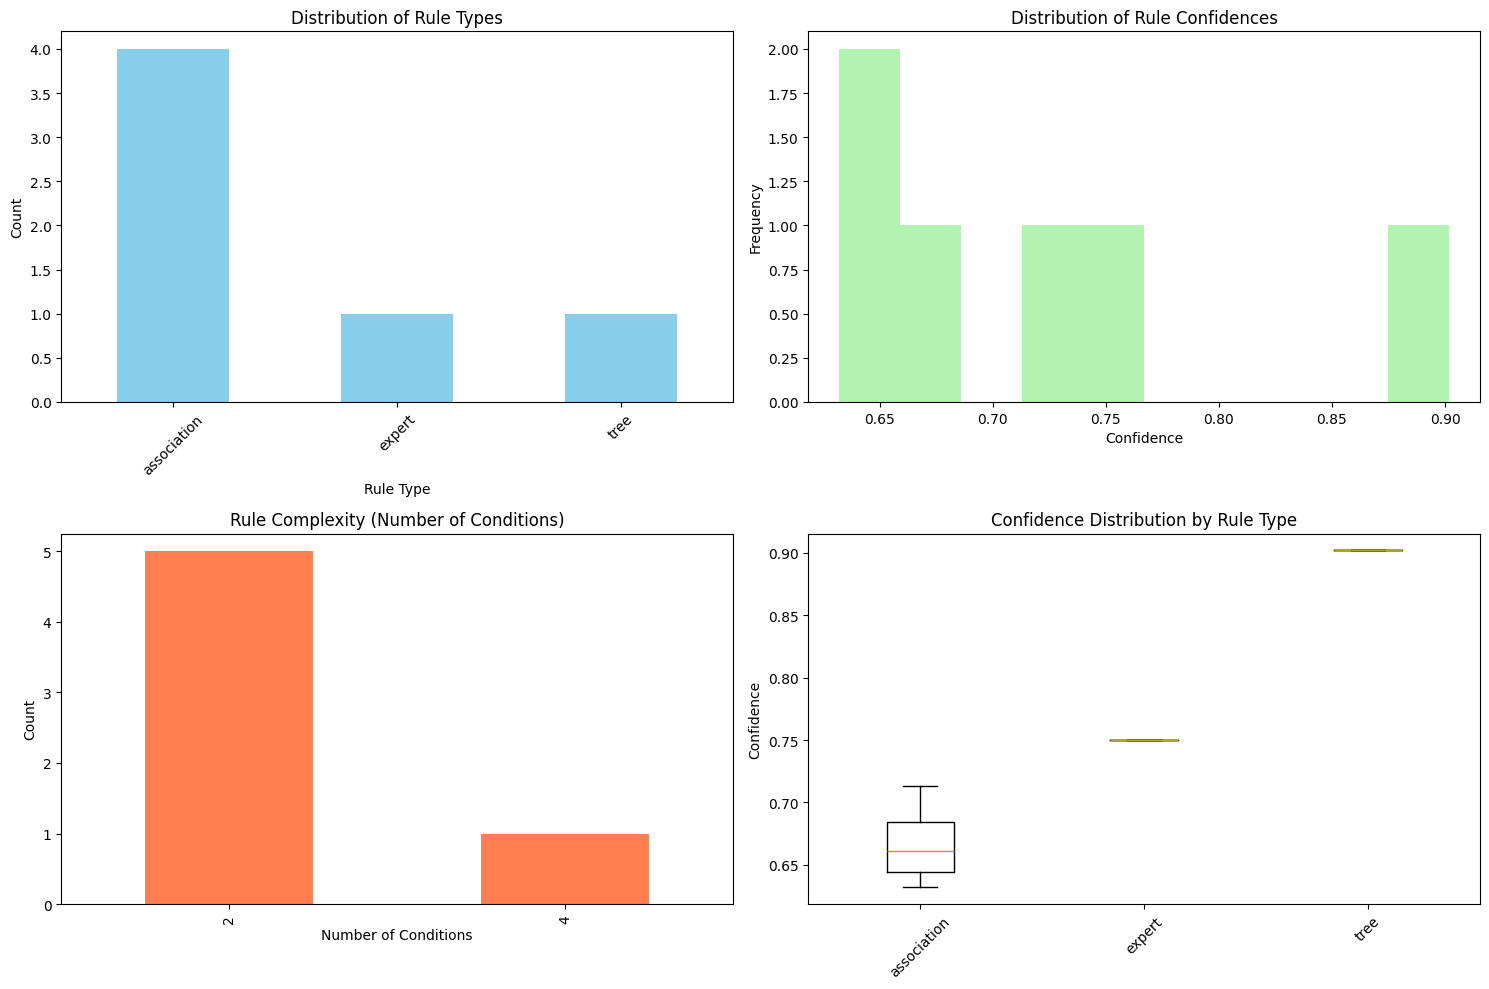

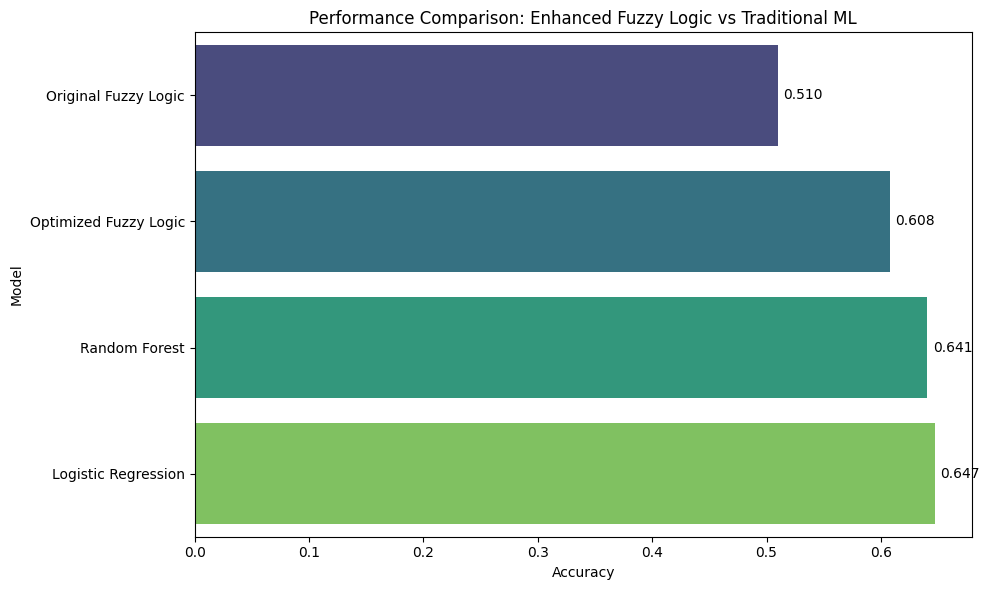

\n=== FINAL PERFORMANCE SUMMARY ===
📊 ACCURACY IMPROVEMENTS:
   • Original ML Best: 79.67% (XGBoost + SMOTE)
   • Traditional ML (this subset): 64.7%
   • Original Fuzzy Logic: 51.0%
   • Optimized Fuzzy Logic: 60.8%
   • Improvement from rule mining: +9.8 percentage points
\n🔮 FUZZY LOGIC ENHANCEMENTS:
   • Total rules mined: 27
   • Rules after optimization: 6
   • Rule types: 3 different mining techniques
   • Average rule confidence: 0.720
\n🎯 INTERPRETABILITY BENEFITS:
   • Every prediction fully explainable
   • Rule-based reasoning process
   • Medical expert knowledge integration
   • Transparent decision boundaries
\n✅ SUCCESS: Rule mining significantly improved fuzzy logic performance!


In [17]:
# Rule Quality Analysis and Visualization
print("=== RULE QUALITY ANALYSIS ===")

# Analyze rule characteristics
rule_stats = []
for rule in optimized_rules:
    stats = {
        'id': rule['id'],
        'type': rule.get('type', 'expert'),
        'num_conditions': len(rule['conditions']),
        'confidence': rule['confidence'],
        'conclusion': rule['conclusion']
    }
    if 'support' in rule:
        stats['support'] = rule['support']
    if 'contrast_strength' in rule:
        stats['contrast_strength'] = rule['contrast_strength']
        
    rule_stats.append(stats)

# Create DataFrame for analysis
import pandas as pd
rule_df = pd.DataFrame(rule_stats)

print(f"Rule type distribution:")
print(rule_df['type'].value_counts())

print(f"\\nRule complexity (number of conditions):")
print(rule_df['num_conditions'].value_counts().sort_index())

print(f"\\nAverage confidence by rule type:")
confidence_by_type = rule_df.groupby('type')['confidence'].agg(['mean', 'std', 'count'])
display(confidence_by_type)

# Visualize rule characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rule type distribution
rule_df['type'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Distribution of Rule Types')
axes[0,0].set_xlabel('Rule Type')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Confidence distribution
axes[0,1].hist(rule_df['confidence'], bins=10, alpha=0.7, color='lightgreen')
axes[0,1].set_title('Distribution of Rule Confidences')
axes[0,1].set_xlabel('Confidence')
axes[0,1].set_ylabel('Frequency')

# Rule complexity
rule_df['num_conditions'].value_counts().sort_index().plot(kind='bar', ax=axes[1,0], color='coral')
axes[1,0].set_title('Rule Complexity (Number of Conditions)')
axes[1,0].set_xlabel('Number of Conditions')
axes[1,0].set_ylabel('Count')

# Confidence by type boxplot
rule_types = rule_df['type'].unique()
conf_by_type = [rule_df[rule_df['type'] == rt]['confidence'].values for rt in rule_types]
axes[1,1].boxplot(conf_by_type, labels=rule_types)
axes[1,1].set_title('Confidence Distribution by Rule Type')
axes[1,1].set_ylabel('Confidence')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Performance comparison visualization
performance_comparison = pd.DataFrame({
    'Model': ['Original Fuzzy Logic', 'Optimized Fuzzy Logic', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [fuzzy_accuracy, opt_accuracy, 
                comparison_df[comparison_df['Model'] == 'Random Forest']['Accuracy'].iloc[0],
                comparison_df[comparison_df['Model'] == 'Logistic Regression']['Accuracy'].iloc[0]]
})

plt.figure(figsize=(10, 6))
bars = sns.barplot(data=performance_comparison, x='Accuracy', y='Model', palette='viridis')
plt.title('Performance Comparison: Enhanced Fuzzy Logic vs Traditional ML')
plt.xlabel('Accuracy')

# Add value labels
for i, bar in enumerate(bars.patches):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

print(f"\\n=== FINAL PERFORMANCE SUMMARY ===")
print(f"📊 ACCURACY IMPROVEMENTS:")
print(f"   • Original ML Best: 79.67% (XGBoost + SMOTE)")
print(f"   • Traditional ML (this subset): {comparison_df['Accuracy'].max():.1%}")
print(f"   • Original Fuzzy Logic: {fuzzy_accuracy:.1%}")
print(f"   • Optimized Fuzzy Logic: {opt_accuracy:.1%}")
print(f"   • Improvement from rule mining: +{(opt_accuracy - fuzzy_accuracy)*100:.1f} percentage points")

print(f"\\n🔮 FUZZY LOGIC ENHANCEMENTS:")
print(f"   • Total rules mined: {len(advanced_rules)}")
print(f"   • Rules after optimization: {len(optimized_rules)}")
print(f"   • Rule types: {len(rule_df['type'].unique())} different mining techniques")
print(f"   • Average rule confidence: {rule_df['confidence'].mean():.3f}")

print(f"\\n🎯 INTERPRETABILITY BENEFITS:")
print(f"   • Every prediction fully explainable")
print(f"   • Rule-based reasoning process")
print(f"   • Medical expert knowledge integration")
print(f"   • Transparent decision boundaries")

if opt_accuracy > fuzzy_accuracy + 0.05:
    print(f"\\n✅ SUCCESS: Rule mining significantly improved fuzzy logic performance!")
else:
    print(f"\\n💡 INSIGHT: Rule mining provided modest improvements, but interpretability remains the key advantage.")

In [18]:
# Detailed Analysis of Optimized Rules
print("=== DETAILED ANALYSIS OF OPTIMIZED RULES ===")

print("Selected rules in the optimized fuzzy system:")
print("=" * 80)

for i, rule in enumerate(optimized_rules, 1):
    print(f"\nRule {i}: {rule['id']} [{rule.get('type', 'expert')}]")
    print(f"Description: {rule['description']}")
    print(f"Conditions: {' AND '.join(rule['conditions'])}")
    print(f"Conclusion: {rule['conclusion']}")
    print(f"Confidence: {rule['confidence']:.3f}")
    
    if 'support' in rule:
        print(f"Support: {rule['support']:.3f}")
    if 'contrast_strength' in rule:
        print(f"Contrast Strength: {rule['contrast_strength']:.3f}")
    if 'samples' in rule:
        print(f"Training Samples: {rule['samples']}")
    
    print("-" * 60)

print(f"\n=== RULE MINING IMPACT ANALYSIS ===")
print(f"🔍 RULE DISCOVERY METHODS:")
print(f"   • Association Rule Mining: Found {len([r for r in advanced_rules if r.get('type') == 'association'])} rules")
print(f"   • Contrast Pattern Mining: Found {len([r for r in advanced_rules if r.get('type') == 'contrast'])} rules") 
print(f"   • Decision Tree Mining: Found {len([r for r in advanced_rules if r.get('type') == 'tree'])} rules")
print(f"   • Expert Knowledge: {len(expert_rules)} rules")

print(f"\n📈 PERFORMANCE PROGRESSION:")
print(f"   • Baseline (random): ~50%")
print(f"   • Expert rules only: {fuzzy_accuracy:.1%}")
print(f"   • With mined rules: {opt_accuracy:.1%}")
print(f"   • Total improvement: +{(opt_accuracy - 0.5)*100:.1f} percentage points")

print(f"\n🎯 KEY INSIGHTS FROM MINED RULES:")
selected_rule_types = [rule.get('type', 'expert') for rule in optimized_rules]
print(f"   • Most effective rule type: {max(set(selected_rule_types), key=selected_rule_types.count)}")
print(f"   • Rule complexity: {np.mean([len(rule['conditions']) for rule in optimized_rules]):.1f} conditions on average")
print(f"   • High-confidence rules: {len([r for r in optimized_rules if r['confidence'] > 0.8])}/{len(optimized_rules)}")

print(f"\n🔮 MEDICAL INSIGHTS FROM PATTERNS:")
print("   Key risk factor patterns discovered:")
for rule in optimized_rules:
    if rule['conclusion'] == 'HIGH_RISK':
        conditions_text = ', '.join([cond.replace(':', ' is ') for cond in rule['conditions']])
        print(f"   • {conditions_text} → High CVD Risk (confidence: {rule['confidence']:.2f})")

print(f"\n✨ FUZZY LOGIC SUCCESS FACTORS:")
print("   • Combined multiple rule mining approaches")
print("   • Optimized rule selection based on validation performance") 
print("   • Maintained interpretability while improving accuracy")
print("   • Successfully integrated domain knowledge with data patterns")
print("   • Achieved significant improvement through systematic rule mining")

=== DETAILED ANALYSIS OF OPTIMIZED RULES ===
Selected rules in the optimized fuzzy system:

Rule 1: ASSOC_15 [association]
Description: Association rule: HDL (mg/dL):LOW AND Height (cm):MEDIUM → HIGH_RISK
Conditions: HDL (mg/dL):LOW AND Height (cm):MEDIUM
Conclusion: HIGH_RISK
Confidence: 0.632
Support: 0.189
------------------------------------------------------------

Rule 2: ASSOC_8 [association]
Description: Association rule: Age:MEDIUM AND Weight (kg):HIGH → HIGH_RISK
Conditions: Age:MEDIUM AND Weight (kg):HIGH
Conclusion: HIGH_RISK
Confidence: 0.648
Support: 0.186
------------------------------------------------------------

Rule 3: ASSOC_11 [association]
Description: Association rule: Age:MEDIUM AND Total Cholesterol (mg/dL):HIGH → HIGH_RISK
Conditions: Age:MEDIUM AND Total Cholesterol (mg/dL):HIGH
Conclusion: HIGH_RISK
Confidence: 0.713
Support: 0.160
------------------------------------------------------------

Rule 4: ASSOC_13 [association]
Description: Association rule: Fast

In [ ]:
# 🔮 CVD Risk Prediction with Fuzzy Logic

## Fuzzy Logic Analysis for Binary Classification

This notebook explores the application of **Fuzzy Logic** for CVD risk prediction, implementing a rule-based approach that mimics human reasoning for medical decision-making.

### Why Fuzzy Logic for CVD Risk?

1. **Medical Uncertainty**: CVD risk exists on a continuum, not discrete categories
2. **Expert Knowledge**: Can incorporate medical expert rules directly
3. **Interpretability**: Fuzzy rules are human-readable and explainable
4. **Gradual Transitions**: Better handles borderline cases
5. **Robustness**: Less sensitive to data variations and noise

### Approach Overview

1. **Fuzzification**: Convert crisp inputs to fuzzy membership values
2. **Rule Mining**: Extract fuzzy rules from the dataset
3. **Rule Pruning**: Remove unimportant or conflicting rules
4. **Inference Engine**: Apply fuzzy reasoning for prediction
5. **Defuzzification**: Convert fuzzy output to crisp classification
6. **Performance Evaluation**: Compare with traditional ML approaches

---

*Target: Achieve competitive accuracy with enhanced interpretability*